# Практический Machine Learning > Занятие 3 > Домашнее задание

Нужно решить задачу с помощью 3х методов:
- кнн
- дерева принятия решения
- логистической регрессии

и залить, на ваш взгляд, лучшее решение.

https://www.kaggle.com/c/sfmlo-6-classification

In [63]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

In [64]:
df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv', sep=',')

In [65]:
df_train.head()

,_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,df7489733b004bbe40d3d37b34f82419,54,technician,married,professional.course,unknown,no,no,cellular,aug,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,905a0b9a5456ee962223033473666be3,36,services,single,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,02d69c07ec6d68e31d641edd45ce61cd,53,blue-collar,married,basic.4y,no,yes,no,cellular,aug,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
3,e492fbe0cccaf67cdb5c0944dbc8a167,34,blue-collar,married,basic.9y,no,yes,yes,telephone,may,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,ac2dc6f5835bdea8e71dd99b65208d07,29,services,single,university.degree,no,yes,no,telephone,aug,...,1,999,0,nonexistent,-1.7,94.027,-38.3,0.890,4991.6,0


In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24712 entries, 0 to 24711
Data columns (total 22 columns):
_id               24712 non-null object
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64
dtypes: floa

In [67]:
# распределение клиентов согласившихся на депозит
df_train['target'].value_counts()

0    21925
1     2787
Name: target, dtype: int64

In [68]:
corr_matrix = df_train.drop(['_id', 'education', 'default', 'housing', 'loan', 'contact',
                           'month', 'day_of_week', 'poutcome'], axis=1).corr()

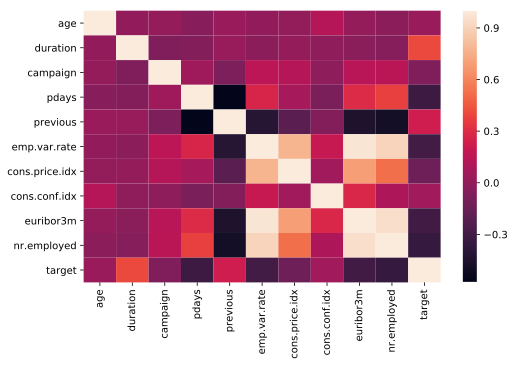

In [69]:
sns.heatmap(corr_matrix);

In [70]:
# duration сильно коррелирует с таргетом... попробуем найти какой то признак дополнительный
df_train['duration'][df_train['target'] == 0].median(), df_train['duration'][df_train['target'] == 1].median()

(163.0, 442.0)

In [71]:
#df_train.groupby(['age'])['target'].value_counts()

## Обрабатываем данные

In [72]:
def preproc_data (df_input):
    df_output = df_input.copy()
    
    #  1) удаляем _id
    df_output.drop('_id', axis = 1, inplace = True)
    
    #  2) 
    df_output.loc[:,  'contact'] = df_output.loc[:,  'contact'].replace({'telephone': 1,
                                                                         'cellular': 0})
    
    # 3) Создаем дополнительный столбец признак длительности разговора duration
    df_output['cons.conf.idx'] *= -1
    
    # 4) duration 3 min
    df_train['duration_3'] = df_train['duration'].apply(lambda x: 0 if x > 180 else 1)
    
    # 5) pdays 999 
    df_train['pdays_999'] = df_train['pdays'].apply(lambda x: 1 if x == 999 else 0)
    
    # 6) 
    df_train['previous_0'] = df_train['previous'].apply(lambda x: 0 if x == 0 else 1)
    
    # 7) Кодируем категориальные признаки
    object_columns = ['education', 'marital','job', 'month','day_of_week','poutcome',
                     'default', 'housing', 'loan'] 
    
    df_output = pd.get_dummies(df_output, columns=object_columns)
    
#     # удаляем столбцы для теста модели
#     df_output.drop([ 'default', 'housing', 'loan'], 
#                   axis=1, inplace= True)
    
    
    
    return df_output

In [73]:
df = preproc_data(df_train)

In [74]:
df.head()

,age,contact,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,poutcome_success,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,54,0,87,1,999,0,1.4,93.444,36.1,4.963,...,0,0,1,0,1,0,0,1,0,0
1,36,1,291,1,999,0,1.1,93.994,36.4,4.857,...,0,1,0,0,1,0,0,1,0,0
2,53,0,182,1,999,0,1.4,93.444,36.1,4.965,...,0,1,0,0,0,0,1,1,0,0
3,34,1,180,2,999,0,1.1,93.994,36.4,4.857,...,0,1,0,0,0,0,1,0,0,1
4,29,1,6,1,999,0,-1.7,94.027,38.3,0.890,...,0,1,0,0,0,0,1,1,0,0


In [75]:
#corr_matrix_preproc = df.corr()

In [76]:
#corr_matrix_preproc['target'].sort_values()

### Выделяем таргет

In [77]:
Y_train = list(df['target'])
X_train = df.drop(['target'], axis = 1)

### Загрузка моделей и метрик

In [78]:
# model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [79]:
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

In [80]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 777

# Определяем оптимальные гиперпараметры моделей

## 1) DecisionTreeClassifier - дерева принятия решения

In [81]:
# Определим пространство поиска

param_grid_d = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 12),
    'min_samples_leaf': randint(5, 120),
    'class_weight': [None, 'balanced']}

cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

model_d = DecisionTreeClassifier(random_state=RND_SEED)

random_search_d = RandomizedSearchCV(model_d, param_distributions=param_grid_d, n_iter=10000, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=RND_SEED)

In [82]:
%%time
random_search_d.fit(X_train, Y_train)

Wall time: 12min 48s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True),
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=777,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10000, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A4D2AC518>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A529182E8>, 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=777, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [21]:
random_search_d.best_params_, random_search_d.best_score_

({'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 85},
 0.9379645076691113)

In [22]:
model_best_d = random_search_d.best_estimator_

## 2) KNeighborsClassifier - метод ближайших соседей

In [23]:
param_grid_k = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
     'leaf_size': randint(30, 50),
     'metric': ['minkowski', 'euclidean'],
     'n_neighbors': randint(3, 12),
     'weights': ['uniform', 'distance']
}


cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

In [24]:
model_k = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')

In [25]:
random_search_k = RandomizedSearchCV(model_k, param_distributions=param_grid_k, n_iter=20, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=RND_SEED)

In [26]:
%%time
random_search_k.fit(X_train, Y_train)

Wall time: 5min 32s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True),
          error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A4CC17198>, 'metric': ['minkowski', 'euclidean'], 'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A4CC0E0F0>, 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=777, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [27]:
random_search_k.best_params_ , random_search_k.best_score_

({'algorithm': 'ball_tree',
  'leaf_size': 35,
  'metric': 'euclidean',
  'n_neighbors': 11,
  'weights': 'uniform'},
 0.9042149113793835)

In [28]:
model_best_k = random_search_k.best_estimator_

## 3) LogisticRegression - Логистическая регрессия

In [29]:
model_l = LogisticRegression()

In [30]:
# 1) набор
param_grid_l_1 = {
    'solver': ['liblinear', 'saga'],
    'penalty':['l1', 'l2'],
    'max_iter': randint(100, 500),
}


cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

In [31]:
random_search_l_1 = RandomizedSearchCV(model_l, param_distributions=param_grid_l_1, n_iter=25, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=RND_SEED)

In [32]:
%%time
random_search_l_1.fit(X_train, Y_train)

Wall time: 18min 17s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A4D1C80F0>},
          pre_dispatch='2*n_jobs', random_state=777, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [33]:
random_search_l_1.best_params_, random_search_l_1.best_score_

({'max_iter': 424, 'penalty': 'l1', 'solver': 'liblinear'}, 0.9325963288700271)

In [34]:
model_best_l_1 = random_search_l_1.best_estimator_

In [35]:
# 2) набор
param_grid_l_2 = {
    'solver': ['newton-cg','lbfgs', 'sag'],
    'penalty':['l2'], 
    'max_iter': randint(200, 1000),
}


cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

In [36]:
random_search_l_2 = RandomizedSearchCV(model_l, param_distributions=param_grid_l_2, n_iter=25, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=RND_SEED)

In [37]:
%%time
random_search_l_2.fit(X_train, Y_train)

Wall time: 12min 16s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2'], 'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A4CC0EBA8>},
          pre_dispatch='2*n_jobs', random_state=777, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [38]:
random_search_l_2.best_params_, random_search_l_2.best_score_

({'max_iter': 839, 'penalty': 'l2', 'solver': 'newton-cg'}, 0.9329835708810995)

In [39]:
model_best_l_2 = random_search_l_2.best_estimator_

In [40]:
print ('ROC AUC \n DecisionTreeClassifier: {} \n KNeighborsClassifier: {} \n LogisticRegression 1: {} \n LogisticRegression 2: {}'.format(random_search_d.best_score_, random_search_k.best_score_,random_search_l_1.best_score_,random_search_l_2.best_score_))

ROC AUC 
 DecisionTreeClassifier: 0.9379645076691113 
 KNeighborsClassifier: 0.9042149113793835 
 LogisticRegression 1: 0.9325963288700271 
 LogisticRegression 2: 0.9329835708810995


## Строим ROC-AUC кривые лучших моделей

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X, X_test, y, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=RND_SEED)

In [43]:
X.shape, X_test.shape

((17298, 62), (7414, 62))

In [44]:
predict_proba_d = model_best_d.predict_proba(X_test)
predict_proba_l_1 = model_best_l_1.predict_proba(X_test)
predict_proba_l_2 = model_best_l_2.predict_proba(X_test)

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr_d, tpr_d, thresholds_d = roc_curve(y_test, predict_proba_d[:,1])
fpr_l_1, tpr_l_1, thresholds_l_1 = roc_curve(y_test, predict_proba_l_1[:,1])
fpr_l_2, tpr_l_2, thresholds_l_2 = roc_curve(y_test, predict_proba_l_2[:,1])

NameError: name 'fpr_n' is not defined

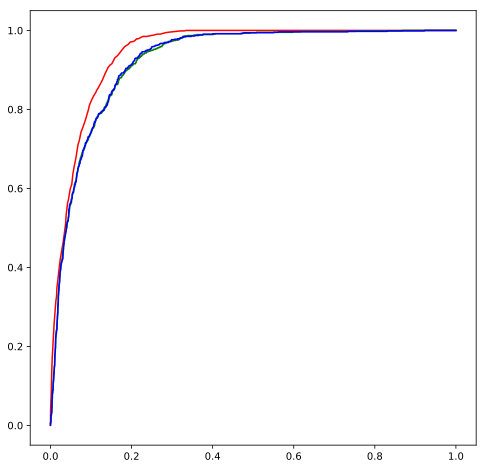

In [83]:
# строим roc-auc кривую
plt.figure(figsize=(8,8))
plt.plot(fpr_d,tpr_d,'r', label='DecisionTreeClassifier')
plt.plot(fpr_l_1,tpr_l_1,'g', label='LogisticRegression - 1')
plt.plot(fpr_l_2,tpr_l_2,'b', label='LogisticRegression - 2')
plt.plot(fpr_n,tpr_n,'r', label='KNeighborsClassifier')
plt.plot([0,1],[0,1])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend()

# По лучшей моделе готовим данные для выгрузки на kaggle

In [55]:
id_submission = list(df_test['_id'])

In [56]:
df_preproc_test = preproc_data(df_test)

In [57]:
#df_preproc_test.head()

In [58]:
target = model_best_d.predict(df_preproc_test)

In [59]:
#target

In [60]:
df_submission = pd.DataFrame({'_id':id_submission,'target':target})

In [61]:
#df_submission.head()

In [62]:
df_submission.to_csv('result_submission.csv', sep=',', encoding='utf-8',index=False)